In [6]:
pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


In [18]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn import metrics
########### mflow ############
import mlflow
import mlflow.sklearn
########### mflow ############

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sharelib import *
from report import *

import logging
from pathlib import Path
import json
import glob
import sys
import pickle

import urllib3

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

jenkinsURL = getArgs(1,"")
mlflowMinioFolder = getArgs(2,"")
mlflowTrainingFileLimit = int(getArgs(13,1))
jenkinsBuildID = getArgs(14,"1")

In [19]:
if __name__ == "__main__":
    df = pd.DataFrame()
    path_to_json = 'rawdata8' 
    json_pattern = os.path.join(path_to_json,'*.txt')
    file_list = glob.glob(json_pattern)
    
    xcount = 0

    for file in file_list:
        xcount = xcount + 1
        print("xcount: ", xcount)
        print(file)
        data = pd.read_json(file, lines=True)
        df = pd.concat([df,data], ignore_index = True)
        if (xcount == mlflowTrainingFileLimit):
            break

xcount:  1
rawdata8\ls.s3.03ce9eec-a45b-4df8-bd15-2a74f81abd46.2023-11-03T08.06.part306.txt


In [20]:
    np.set_printoptions(threshold=sys.maxsize)
    
    # df_categories = df[df["ads_country_dst"].str.startswith(('1', '2', '3', '4', '5', '6', '7', '8', '9', '0')) == False] 
    df_categories = pd.concat([df["ads_country_dst"]], axis=1, sort=False,)
    print("-------------- Count Record --------------")
    print(df_categories.shape[0])
    print("-------------- Count Record --------------")
    print("-------------- Count Destination Country --------------")
    print(df_categories.value_counts().to_string())
    print("-------------- Count Destination Country --------------")

    countryMap = mapOfCountryDst()
    portMap = mapOfPort()
    print("-------------- Number of Country in Encoding --------------")
    print("country_key : ", len(countryMap.keys()))
    print("country_count : ", len(set(countryMap.values())))
    print("-------------- Number of Country in Encoding --------------")    
    print("-------------- Show Country Not in list --------------")
    print(df_categories[~df_categories['ads_country_dst'].isin(countryMap.keys())].value_counts().to_string())
    print("-------------- Show Country Not in list --------------")

-------------- Count Record --------------
32029
-------------- Count Record --------------
-------------- Count Destination Country --------------
ads_country_dst                 
Thailand                            19120
United States                        6721
Singapore                             750
China                                 711
Japan                                 688
Malaysia                              662
Netherlands                           611
Canada                                279
France                                213
Germany                               212
Korea Republic Of                     172
United Kingdom                        157
Russian Federation                    154
Hong Kong                             138
Australia                             111
Brazil                                 98
Asia Pacific Region                    96
India                                  92
Viet Nam                               79
Spain                

In [21]:
    df_categories = df_categories.mask(~df_categories.isin(countryMap.keys()),'OTHER')
    print("Mask OTHER done")
    X = df_categories.replace({'ads_country_dst': countryMap})
    print("Frequency encoding done")
    print("-------------- Show X --------------")
    print(X)
    print("-------------- Show X --------------")
    # x_scaler = StandardScaler().fit(X)
    # print("Mean of x is:", x_scaler.mean_)
    # print("Variance of x is:", x_scaler.var_)
    # print("Standard deviation of x is:", x_scaler.scale_)
    # x_scaled = x_scaler.transform(X)
    # print(x_scaled)
    print("-------------- Port --------------")
    df_categories = pd.concat([df_categories,df["ads_dst_port"]], axis=1, sort=False,)
    ads_dst_port = pd.concat([df["ads_dst_port"]], axis=1, sort=False,).astype(str)
    ads_dst_port = ads_dst_port.mask(~ads_dst_port.isin(portMap.keys()), 'OTHER')
    ads_dst_port = ads_dst_port.replace({'ads_dst_port': portMap})
    print("-------------- Port --------------")

    X = pd.concat([X,ads_dst_port], axis=1, sort=False,)
    print("-------------- Show X --------------")
    print(X.to_string())    
    print("-------------- Show X --------------")
    
    normalPoint = 30
    mask = (X['ads_country_dst'] <= normalPoint) & (X['ads_dst_port'] == 0)
    X_Test = pd.DataFrame({'test': [-1] * len(df)})
    X_Test.loc[mask, 'test'] = 1

    print("-------------- Show X_Test --------------")
    print(X_Test)
    print("-------------- Show X_Test --------------")
    

Mask OTHER done
Frequency encoding done
-------------- Show X --------------
       ads_country_dst
0                    2
1                    0
2                    2
3                    0
4                    2
...                ...
32024                0
32025                2
32026                0
32027                2
32028                2

[32029 rows x 1 columns]
-------------- Show X --------------
-------------- Port --------------
-------------- Port --------------
-------------- Show X --------------
       ads_country_dst  ads_dst_port
0                    2             0
1                    0             0
2                    2             0
3                    0             0
4                    2             0
5                    0             0
6                    0             0
7                   13             0
8                    2             0
9                   13             0
10                   2             0
11                   9           

In [22]:
# Call and fit the Local Outlier Factor detector
# lof_detector = LocalOutlierFactor(n_neighbors=30, contamination=0.001,novelty=True).fit(x_scaled)
setNNeighbors = int((df_categories.shape[0]/300))
print("set n_neighbors : " , setNNeighbors)
lof_detector = LocalOutlierFactor(n_neighbors=setNNeighbors, contamination=0.1,novelty=True).fit(X.values)

print("-------------- Model Size (MB) --------------")
print("{:.2f}".format(sys.getsizeof(pickle.dumps(lof_detector))/(1024*1024)))
print("-------------- Model Size (MB) --------------")

# lof_detect = lof_detector.predict(x_scaled)
lof_detect = lof_detector.predict(X)

set n_neighbors :  106
-------------- Model Size (MB) --------------
27.74
-------------- Model Size (MB) --------------


In [23]:
recordDetect,countDetect = np.unique(lof_detect, return_counts=True)
print("--------------Count Anomaly VS Normal-------------")
print(recordDetect)
print(countDetect)

if (len(countDetect) == 1):
    row_to_be_added = countDetect
    countDetect = np.append(np.array([0]),row_to_be_added,axis=0)

print("Anomaly = " , countDetect[0] , "record with " , (countDetect[0])*100/(countDetect[0]+countDetect[1]) ," %")
print("Normal  = " , countDetect[1] , "record with " , (countDetect[1])*100/(countDetect[0]+countDetect[1]) ," %")
print("--------------Count Anomaly VS Normal-------------")

htmlAnomalyVSNormally = '''
<table class="table table-striped">
    <th>Type</th><th class=right-aligned>Record</th><th class=right-aligned>%Record</th>
    <tr><td>Anomaly</td><td class=right-aligned>''' + str(countDetect[0]) + '''</td><td class=right-aligned> ''' + str((countDetect[0])*100/(countDetect[0]+countDetect[1])) + '''</td></tr>
    <tr><td>Normal</td><td class=right-aligned>''' + str(countDetect[1]) + '''</td><td class=right-aligned> ''' + str((countDetect[1])*100/(countDetect[0]+countDetect[1])) + '''</td></tr>
</table>
'''

--------------Count Anomaly VS Normal-------------
[-1  1]
[  982 31047]
Anomaly =  982 record with  3.0659714633613286  %
Normal  =  31047 record with  96.93402853663868  %
--------------Count Anomaly VS Normal-------------


In [24]:
print("-------------- List Destination Country Port with Prediction -------------")
# print(type(df_categories.value_counts()))
# print(type(df_categories))

htmlItem = ""

for index, value in df_categories.value_counts().items():
    encode = countryMap[index[0]]

    portEncode = 0
    if (str(index[1]) in portMap):
        portEncode = portMap[str(index[1])]

    predictData = lof_detector.predict([[ encode , portEncode ]])

    # if (portEncode > 0 and predictData[0] == 1):
    print(index[0]  , " | code =" , encode , " | Port Level = ", index[1] , "/" , str(portEncode)  , " | count ="  , value , " | result =" , dataPredictionToString(predictData[0]))
    
    htmlItem = htmlItem + "<tr><td>" + index[0] + "</td><td class=right-aligned>" + str(encode) + "</td><td class=right-aligned>" + str(index[1]) + "</td><td class=right-aligned>" + str(portEncode) + "</td><td class=right-aligned>" + str(value)+ "</td><td>" + dataPredictionToString(predictData[0]) + "</td><tr>"
print("-------------- List Destination Country with Prediction -------------")

htmlCountryPrediction = '''
<table class="table table-striped">
    <th>Country</th><th class=right-aligned>CODE</th><th class=right-aligned>Port</th><th class=right-aligned>Malware DST Ports Level</th><th class=right-aligned>Amount</th><th>Prediction</th>
    ''' + htmlItem + '''
</table>
'''

-------------- List Destination Country Port with Prediction -------------
Thailand  | code = 2  | Port Level =  53 / 0  | count = 11664  | result = Normally
United States  | code = 0  | Port Level =  443 / 0  | count = 2512  | result = Normally
United States  | code = 0  | Port Level =  53 / 0  | count = 2071  | result = Normally
United States  | code = 0  | Port Level =  445 / 0  | count = 1616  | result = Normally
Thailand  | code = 2  | Port Level =  443 / 0  | count = 942  | result = Normally
Thailand  | code = 2  | Port Level =  123 / 0  | count = 702  | result = Normally
Malaysia  | code = 13  | Port Level =  443 / 0  | count = 615  | result = Normally
Singapore  | code = 6  | Port Level =  443 / 0  | count = 491  | result = Normally
Japan  | code = 7  | Port Level =  443 / 0  | count = 418  | result = Normally
China  | code = 4  | Port Level =  445 / 0  | count = 372  | result = Normally
Thailand  | code = 2  | Port Level =  80 / 0  | count = 350  | result = Normally
Thailand  

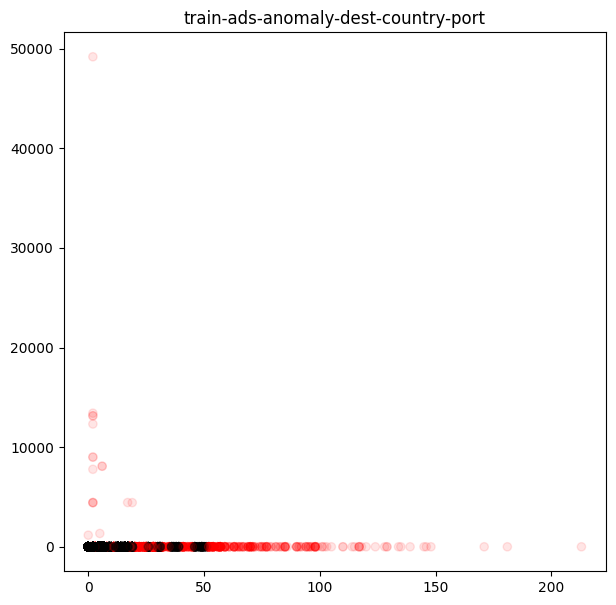

In [25]:
plt.figure(figsize=(7,7))
# plt.scatter(x_scaled[:, 0], x_scaled[:, 0], c=lof_detect, cmap="flag", alpha=0.5)
plt.scatter(X.to_numpy()[:, 0], X.to_numpy()[:, 1], c=lof_detect, cmap="flag", alpha=0.1)
plt.title("train-ads-anomaly-dest-country-port")
plt.savefig('images/train-ads-anomaly-dest-country-port.png')
plt.show()

In [26]:
print("-------------- Machine Learning - Confusion Matrix -------------")
Accuracy = metrics.accuracy_score(X_Test, lof_detect)
print("Accuracy : " , Accuracy)
Precision = metrics.precision_score(X_Test, lof_detect)
print("Precision : " , Precision)
Sensitivity_recall = metrics.recall_score(X_Test, lof_detect)
print("Sensitivity_recall : " , Sensitivity_recall)
Specificity = metrics.recall_score(X_Test, lof_detect, pos_label=-1)
print("Specificity : " , Specificity)
F1_score = metrics.f1_score(X_Test, lof_detect)
print("F1_score : " , F1_score)
print("-------------- Machine Learning - Confusion Matrix -------------")

htmlMatrix = '''
<table class="table table-striped">
    <th>Type</th><th>Meaning</th><th class=right-aligned>Score</th>
    <tr><td>Accuracy</td><td>The proportion of correctly predicted cases</td><td class=right-aligned>''' + str(Accuracy) + '''</td></tr>
    <tr><td>Precision</td><td>Positive Predictive Value</td><td class=right-aligned>''' + str(Precision) + '''</td></tr>
    <tr><td>Sensitivity_recall</td><td> True Positive Rate</td><td class=right-aligned>''' + str(Sensitivity_recall) + '''</td></tr>
    <tr><td>Specificity</td><td>True Negative Rate</td><td class=right-aligned>''' + str(Specificity) + '''</td></tr>
    <tr><td>F1_score</td><td>Balances precision and recall</td><td class=right-aligned>''' + str(F1_score) + '''</td></tr>    
</table>
'''

-------------- Machine Learning - Confusion Matrix -------------
Accuracy :  0.9714945830341253
Precision :  0.9910780429671143
Sensitivity_recall :  0.9797490925300898
Specificity :  0.5553772070626003
F1_score :  0.9853810065169007
-------------- Machine Learning - Confusion Matrix -------------


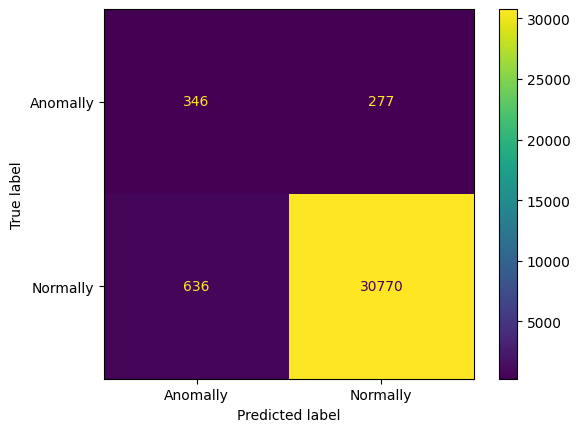

In [27]:
confusion_matrix = metrics.confusion_matrix(X_Test, lof_detect)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Anomally", "Normally"])
cm_display.plot()
plt.savefig('images/train-ads-anomaly-dest-country-port-confusion-matrix.png')
plt.show()

In [28]:
summary_table = '''
<p>Count Record : ''' + str(df_categories.shape[0]) + '''</p>
<h2>Local Outlier Factor (LOF)</h2>
<p>n_neighbors : ''' + str(setNNeighbors) + '''</p>
''' + htmlAnomalyVSNormally + '''
''' + htmlCountryPrediction + '''
<table class="table table-striped">
<th>Local Outlier Factor (LOF)</th>
<tr>
    <td><img src="train-ads-anomaly-dest-country-port-port.png" alt="train-ads-anomaly-dest-country-port.png"></td>
</tr>
    </table>
<table class="table table-striped">
<th>confusion-matrix</th>
<tr>
    <td><img src="train-ads-anomaly-dest-country-port-confusion-matrix.png" alt="confusion-matrix"></td>
</tr>
</table>
''' + htmlMatrix + '''
'''

In [29]:
html_string = mainReportHTML("train-ads-anomaly-dest-country-port",summary_table)

In [30]:
f = open('report.html','w')
f.write(html_string)
f.close()

In [34]:
env_vars = os.environ

# Print each item in the dictionary
for key, value in env_vars.items():
    print(f'{key}: {value}')

ALLUSERSPROFILE: C:\ProgramData
APPDATA: C:\Users\sutee.k\AppData\Roaming
CHROME_CRASHPAD_PIPE_NAME: \\.\pipe\crashpad_12084_TGNFHJLRYRFUCTQY
COMMONPROGRAMFILES: C:\Program Files\Common Files
COMMONPROGRAMFILES(X86): C:\Program Files (x86)\Common Files
COMMONPROGRAMW6432: C:\Program Files\Common Files
COMPUTERNAME: LAPTOP-JPA5UF21
COMSPEC: C:\WINDOWS\system32\cmd.exe
DRIVERDATA: C:\Windows\System32\Drivers\DriverData
ELECTRON_RUN_AS_NODE: 1
HOMEDRIVE: C:
HOMEPATH: \Users\sutee.k
JAVA_HOME: C:\Program Files\Java\jdk-11.0.8
JPY_INTERRUPT_EVENT: 3976
LOCALAPPDATA: C:\Users\sutee.k\AppData\Local
LOGONSERVER: \\LAPTOP-JPA5UF21
MOZ_PLUGIN_PATH: C:\Program Files\Tracker Software\PDF Viewer\Win32\
NUMBER_OF_PROCESSORS: 8
ONEDRIVE: C:\Users\sutee.k\OneDrive
ONEDRIVECONSUMER: C:\Users\sutee.k\OneDrive
ORIGINAL_XDG_CURRENT_DESKTOP: undefined
OS: Windows_NT
PATH: c:\Program Files\Python39;c:\Users\sutee.k\AppData\Roaming\Python\Python39\Scripts;C:\Program Files\Python39\Scripts\;C:\Program Files\P

In [37]:
os.environ['MLFLOW_HTTP_REQUEST_TIMEOUT'] = '5000'

In [39]:
env_vars = os.environ

# Print each item in the dictionary
for key, value in env_vars.items():
    print(f'{key}: {value}')

ALLUSERSPROFILE: C:\ProgramData
APPDATA: C:\Users\sutee.k\AppData\Roaming
CHROME_CRASHPAD_PIPE_NAME: \\.\pipe\crashpad_12084_TGNFHJLRYRFUCTQY
COMMONPROGRAMFILES: C:\Program Files\Common Files
COMMONPROGRAMFILES(X86): C:\Program Files (x86)\Common Files
COMMONPROGRAMW6432: C:\Program Files\Common Files
COMPUTERNAME: LAPTOP-JPA5UF21
COMSPEC: C:\WINDOWS\system32\cmd.exe
DRIVERDATA: C:\Windows\System32\Drivers\DriverData
ELECTRON_RUN_AS_NODE: 1
HOMEDRIVE: C:
HOMEPATH: \Users\sutee.k
JAVA_HOME: C:\Program Files\Java\jdk-11.0.8
JPY_INTERRUPT_EVENT: 3976
LOCALAPPDATA: C:\Users\sutee.k\AppData\Local
LOGONSERVER: \\LAPTOP-JPA5UF21
MOZ_PLUGIN_PATH: C:\Program Files\Tracker Software\PDF Viewer\Win32\
NUMBER_OF_PROCESSORS: 8
ONEDRIVE: C:\Users\sutee.k\OneDrive
ONEDRIVECONSUMER: C:\Users\sutee.k\OneDrive
ORIGINAL_XDG_CURRENT_DESKTOP: undefined
OS: Windows_NT
PATH: c:\Program Files\Python39;c:\Users\sutee.k\AppData\Roaming\Python\Python39\Scripts;C:\Program Files\Python39\Scripts\;C:\Program Files\P

In [33]:
%set_env MLFLOW_TRACKING_URI=http://127.0.0.1:5000
# %set_env MLFLOW_TRACKING_URI=http://mlflow.rtarf-ml.its-software-services.com/
tracking_uri = os.environ["MLFLOW_TRACKING_URI"]
# export MLFLOW_TRACKING_USERNAME=user 
# export MLFLOW_TRACKING_PASSWORD=pwd

experiment = mlflow.set_experiment(experiment_name='ads-anomaly-dest-country-port')
experiment_id = experiment.experiment_id

reportURL = "https://minio-api.rtarf-ml.its-software-services.com/ml-report/train-ads-anomaly-dest-country-port/" + jenkinsBuildID + "/report.html"

run_description = f"""
### Note
**All information** * about Training * ~~ML here~~
Jenkins URL: [{jenkinsURL}]({jenkinsURL})
Report: [{reportURL}]({reportURL})
"""
%set_env MLFLOW_HTTP_REQUEST_TIMEOUT=4000

urllib3.util.retry.Retry(total=10, backoff_factor=0.1, status_forcelist=[ 500, 502, 503, 504 ])

with mlflow.start_run(experiment_id=experiment_id,description=run_description):
    mlflow.set_tracking_uri(tracking_uri)
    
    print("Artifact Location: {}".format(experiment.artifact_location))
    print("artifact uri : " + mlflow.get_artifact_uri())

    mlflow.doctor()
    mlflow.log_param("MlflowMinioFolder", mlflowMinioFolder)
    mlflow.log_param("country_key", len(countryMap.keys()))
    mlflow.log_param("country_count", len(set(countryMap.values())))

    mlflow.log_param("SampleFile", xcount)
    mlflow.log_param("SampleRows", X.shape[0])
    # mlflow.set_tag("JenkinsURL",jenkinsURL)

    mlflow.log_metric("Anomaly", str((countDetect[0])*100/(countDetect[0]+countDetect[1])))
    mlflow.log_metric("Normal", str((countDetect[1])*100/(countDetect[0]+countDetect[1])))
    mlflow.sklearn.log_model(lof_detector, "model", registered_model_name="ads-anomaly-by-dest-country")
    print("Model saved in run %s" % mlflow.active_run().info.run_uuid)


print("-------------- Model save success -------------")

env: MLFLOW_TRACKING_URI=http://127.0.0.1:5000
env: MLFLOW_HTTP_REQUEST_TIMEOUT=4000
Artifact Location: mlflow-artifacts:/229825231912337594
artifact uri : mlflow-artifacts:/229825231912337594/9c735225d02f4f3694df05408bd6eb27/artifacts
System information: Windows 10.0.19045
Python version: 3.9.7
MLflow version: 2.1.1
MLflow module location: C:\Users\sutee.k\AppData\Roaming\Python\Python39\site-packages\mlflow\__init__.py
Tracking URI: http://127.0.0.1:5000
Registry URI: http://127.0.0.1:5000
Active experiment ID: 229825231912337594
Active run ID: 9c735225d02f4f3694df05408bd6eb27
Active run artifact URI: mlflow-artifacts:/229825231912337594/9c735225d02f4f3694df05408bd6eb27/artifacts
MLflow environment variables: 
  MLFLOW_HTTP_REQUEST_TIMEOUT: 4000
  MLFLOW_TRACKING_URI: http://127.0.0.1:5000
MLflow dependencies: 
  Flask: 2.3.3
  Jinja2: 3.1.2
  alembic: 1.12.0
  click: 8.1.7
  cloudpickle: 2.2.1
  databricks-cli: 0.17.8
  docker: 6.1.3
  entrypoints: 0.4
  gitpython: 3.1.37
  importli

Registered model 'ads-anomaly-by-dest-country' already exists. Creating a new version of this model...
2023/11/09 23:34:44 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: ads-anomaly-by-dest-country, version 17


Model saved in run 9c735225d02f4f3694df05408bd6eb27
-------------- Model save success -------------


Created version '17' of model 'ads-anomaly-by-dest-country'.


In [10]:
!mlflow models serve -m mlflow-artifacts:/394149324160139362/f188152b48494d1c86de6a4f8397908d/artifacts/model -p 1234 --no-conda

^C


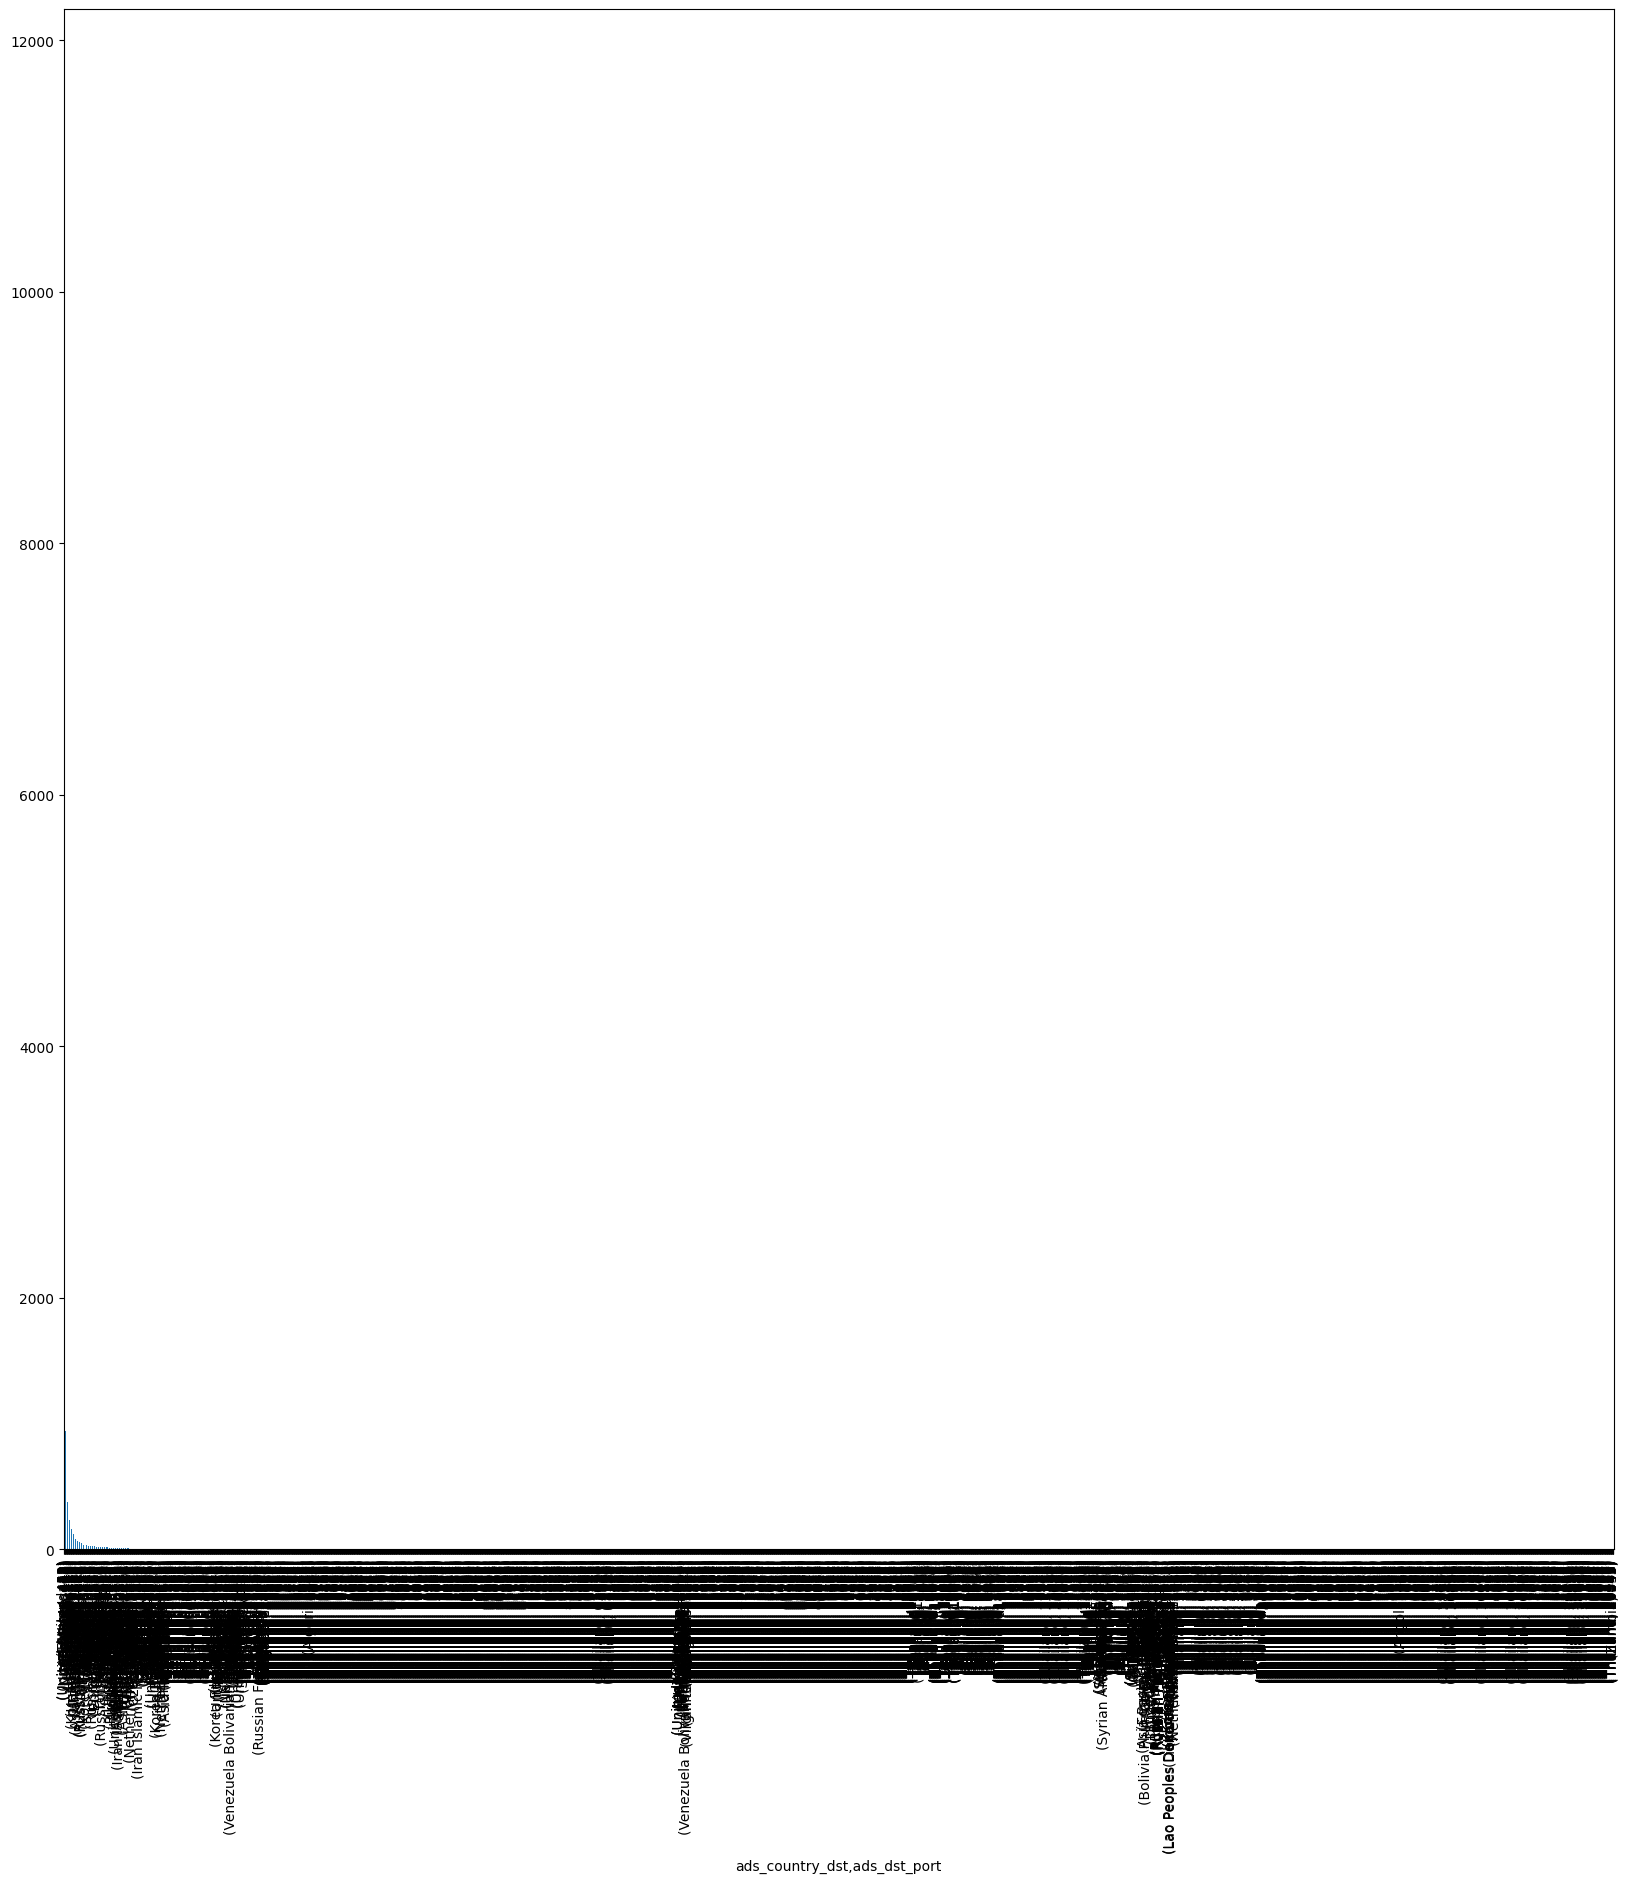

In [11]:
# Plot the conparison between actual and predicted y
df_categories.value_counts()[: :].plot(kind="bar", figsize=(20,20))
plt.show()